# 7 npmsjs, 11 pypi, 28 dockerhub

In [ ]:
dates = ["Nov 22", "Dec 22", "Jan 23", "Feb 23", "May 23", "Jun 23", "Oct 23", "Dec 23"]
values =[152700, 266000000, 616000000, 1000000000, 1850000000, 1660000000, 1700000000, 1600000000]
hf_dates = ["Jun 22", "May 23", "Oct 23", "Apr 24"]


# Setup Functions

## Import Statements

In [2]:
# All import statements
import os
import sys
import time
import json
import requests
import datetime
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import style
import ast
import psycopg2
from tqdm import tqdm
import time
from IPython.display import display
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import sqlite3
# Increase the default pyplot textsize to 30
plt.rcParams.update({'font.size': 20})
NPM = 7
PYPI = 11
DOCKERHUB = 28

/Users/developer/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Query Abstraction Functions

In [3]:
def query_psql(query: str, database : str = "ecosystems_23_10", username : str = "postgres") -> str | None:
    try:
        conn = psycopg2.connect(
            dbname=database,
            user=username
        )
        # print("Connected to database")

        cur = conn.cursor()

        cur.execute(query)

        result = cur.fetchall()

        cur.close()
        conn.close()

        return result
    except Exception as e:
        print(f"An Exception has occurred {e}")
        return None

def query_table_schema(table_name: str) -> str | None:
    schema = query_psql(f"""
            SELECT column_name, data_type, is_nullable, column_default
            FROM information_schema.columns
            WHERE table_name = '{table_name}';""")
    
    schema_df = pd.DataFrame(schema, columns=["Column Name", "Data Type", "Nullable", "Default"])

    return schema_df


def query_registry_name(registry_id: int) -> str | None:
    registry_name = query_psql(f"""
            SELECT name
            FROM registries
            WHERE id = {registry_id};""")

    return registry_name[0][0] if registry_name else None

def query_percentile_to_limit(percentile: int, registry_id: int) -> int | None:
    percentile_query = query_psql(f"""
            SELECT COUNT(*)
            FROM packages
            WHERE registry_id = {registry_id};""")

    if not percentile_query:
        return None

    limit = int(percentile_query[0][0] * percentile / 100)

    return limit

# PeaTMOSS is a SQLite3 database in the same folder as this script
def query_sqlite3(query : str, db : str = 'PeaTMOSS_DIST.db') -> str | None:
    conn = None
    cur = None
    try:
        conn = sqlite3.connect(db, timeout=10)
        cur = conn.cursor()
        cur.execute(query)
        result = cur.fetchall()
        cur.close()
        conn.close()
        return result
    except Exception as e:
        if cur is not None:
            cur.close()
        if conn is not None:
            conn.close()
        print(f"An error occurred: {e}")
        return None

def update_sqlite3(query: str, db : str = 'PeaTMOSS_DIST.db') -> None:
    conn = None
    cur = None
    try:
        conn = sqlite3.connect(db, timeout=10)
        cur = conn.cursor()
        cur.execute(query)
        conn.commit()
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if cur is not None:
            cur.close()
        if conn is not None:
            conn.close()
        return None


## Database Schema

### Packages Schema (PSQL)

In [3]:
"""
ecosystems=# \dt
                List of relations
 Schema |         Name         | Type  |  Owner   
--------+----------------------+-------+----------
 public | ar_internal_metadata | table | postgres
 public | dependencies         | table | postgres
 public | exports              | table | postgres
 public | maintainers          | table | postgres
 public | maintainerships      | table | postgres
 public | packages             | table | postgres
 public | registries           | table | postgres
 public | schema_migrations    | table | postgres
 public | versions             | table | postgres
(9 rows)

ecosystems=# \d maintainers
                                            Table "public.maintainers"
     Column     |              Type              | Collation | Nullable |                 Default                 
----------------+--------------------------------+-----------+----------+-----------------------------------------
 id             | bigint                         |           | not null | nextval('maintainers_id_seq'::regclass)
 registry_id    | integer                        |           |          | 
 uuid           | character varying              |           |          | 
 login          | character varying              |           |          | 
 email          | character varying              |           |          | 
 name           | character varying              |           |          | 
 url            | character varying              |           |          | 
 packages_count | integer                        |           |          | 0
 created_at     | timestamp(6) without time zone |           | not null | 
 updated_at     | timestamp(6) without time zone |           | not null | 
Indexes:
    "maintainers_pkey" PRIMARY KEY, btree (id)
    "index_maintainers_on_registry_id_and_login" UNIQUE, btree (registry_id, login)
    "index_maintainers_on_registry_id_and_uuid" UNIQUE, btree (registry_id, uuid)

ecosystems=# \dt
                List of relations
 Schema |         Name         | Type  |  Owner   
--------+----------------------+-------+----------
 public | ar_internal_metadata | table | postgres
 public | dependencies         | table | postgres
 public | exports              | table | postgres
 public | maintainers          | table | postgres
 public | maintainerships      | table | postgres
 public | packages             | table | postgres
 public | registries           | table | postgres
 public | schema_migrations    | table | postgres
 public | versions             | table | postgres
(9 rows)

ecosystems=# \d dependencies
                                    Table "public.dependencies"
    Column    |       Type        | Collation | Nullable |                 Default                  
--------------+-------------------+-----------+----------+------------------------------------------
 id           | bigint            |           | not null | nextval('dependencies_id_seq'::regclass)
 package_id   | integer           |           |          | 
 version_id   | integer           |           |          | 
 package_name | character varying |           |          | 
 ecosystem    | character varying |           |          | 
 kind         | character varying |           |          | 
 optional     | boolean           |           |          | false
 requirements | character varying |           |          | 
Indexes:
    "dependencies_pkey" PRIMARY KEY, btree (id)
    "index_dependencies_on_ecosystem_and_package_name" btree (ecosystem, package_name)
    "index_dependencies_on_package_id" btree (package_id)
    "index_dependencies_on_version_id" btree (version_id)

ecosystems=# \d exports
                                            Table "public.exports"
     Column     |              Type              | Collation | Nullable |               Default               
----------------+--------------------------------+-----------+----------+-------------------------------------
 id             | bigint                         |           | not null | nextval('exports_id_seq'::regclass)
 date           | character varying              |           |          | 
 bucket_name    | character varying              |           |          | 
 packages_count | integer                        |           |          | 
 created_at     | timestamp(6) without time zone |           | not null | 
 updated_at     | timestamp(6) without time zone |           | not null | 
Indexes:
    "exports_pkey" PRIMARY KEY, btree (id)

ecosystems=# \d maintainers
                                            Table "public.maintainers"
     Column     |              Type              | Collation | Nullable |                 Default                 
----------------+--------------------------------+-----------+----------+-----------------------------------------
 id             | bigint                         |           | not null | nextval('maintainers_id_seq'::regclass)
 registry_id    | integer                        |           |          | 
 uuid           | character varying              |           |          | 
 login          | character varying              |           |          | 
 email          | character varying              |           |          | 
 name           | character varying              |           |          | 
 url            | character varying              |           |          | 
 packages_count | integer                        |           |          | 0
 created_at     | timestamp(6) without time zone |           | not null | 
 updated_at     | timestamp(6) without time zone |           | not null | 
Indexes:
    "maintainers_pkey" PRIMARY KEY, btree (id)
    "index_maintainers_on_registry_id_and_login" UNIQUE, btree (registry_id, login)
    "index_maintainers_on_registry_id_and_uuid" UNIQUE, btree (registry_id, uuid)

ecosystems=# \d maintainerships
                                           Table "public.maintainerships"
    Column     |              Type              | Collation | Nullable |                   Default                   
---------------+--------------------------------+-----------+----------+---------------------------------------------
 id            | bigint                         |           | not null | nextval('maintainerships_id_seq'::regclass)
 package_id    | integer                        |           |          | 
 maintainer_id | integer                        |           |          | 
 role          | character varying              |           |          | 
 created_at    | timestamp(6) without time zone |           | not null | 
 updated_at    | timestamp(6) without time zone |           | not null | 
Indexes:
    "maintainerships_pkey" PRIMARY KEY, btree (id)
    "index_maintainerships_on_maintainer_id" btree (maintainer_id)
    "index_maintainerships_on_package_id" btree (package_id)

ecosystems=# \d packages
                                                  Table "public.packages"
           Column            |              Type              | Collation | Nullable |               Default                
-----------------------------+--------------------------------+-----------+----------+--------------------------------------
 id                          | bigint                         |           | not null | nextval('packages_id_seq'::regclass)
 registry_id                 | integer                        |           |          | 
 name                        | character varying              |           |          | 
 ecosystem                   | character varying              |           |          | 
 description                 | text                           |           |          | 
 homepage                    | character varying              |           |          | 
 licenses                    | character varying              |           |          | 
 repository_url              | character varying              |           |          | 
 normalized_licenses         | character varying[]            |           |          | '{}'::character varying[]
 versions_count              | integer                        |           | not null | 0
 latest_release_published_at | timestamp(6) without time zone |           |          | 
 latest_release_number       | character varying              |           |          | 
 keywords_array              | character varying[]            |           |          | '{}'::character varying[]
 language                    | character varying              |           |          | 
 status                      | character varying              |           |          | 
 last_synced_at              | timestamp(6) without time zone |           |          | 
 created_at                  | timestamp(6) without time zone |           | not null | 
 updated_at                  | timestamp(6) without time zone |           | not null | 
 metadata                    | json                           |           |          | '{}'::json
 repo_metadata               | json                           |           |          | '{}'::json
 repo_metadata_updated_at    | timestamp(6) without time zone |           |          | 
 dependent_packages_count    | integer                        |           |          | 0
 downloads                   | bigint                         |           |          | 
 downloads_period            | character varying              |           |          | 
 dependent_repos_count       | integer                        |           |          | 0
 rankings                    | json                           |           |          | '{}'::json
 namespace                   | character varying              |           |          | 
 advisories                  | json                           |           | not null | '[]'::json
 maintainers_count           | integer                        |           |          | 0
 first_release_published_at  | timestamp(6) without time zone |           |          | 
 keywords                    | character varying[]            |           |          | '{}'::character varying[]
 docker_dependents_count     | integer                        |           |          | 
 docker_downloads_count      | bigint                         |           |          | 
 issue_metadata              | json                           |           |          | 
Indexes:
    "packages_pkey" PRIMARY KEY, btree (id)
    "index_packages_on_registry_id_and_name" UNIQUE, btree (registry_id, name)
    "index_packages_on_forks_count" btree (registry_id, ((repo_metadata ->> 'forks_count'::text)::integer))
    "index_packages_on_keywords" gin (keywords)
    "index_packages_on_latest_release_published_at" btree (latest_release_published_at)
    "index_packages_on_lower_repository_url" btree (lower(repository_url::text))
    "index_packages_on_rankings_average" btree (((rankings ->> 'average'::text)::double precision))
    "index_packages_on_registry_id_and_dependent_packages_count" btree (registry_id, dependent_packages_count)
    "index_packages_on_registry_id_and_dependent_repos_count" btree (registry_id, dependent_repos_count)
    "index_packages_on_registry_id_and_docker_downloads_count" btree (registry_id, docker_downloads_count)
    "index_packages_on_registry_id_and_downloads" btree (registry_id, downloads)
    "index_packages_on_registry_id_and_namespace" btree (registry_id, namespace)
    "index_packages_on_registry_id_and_updated_at" btree (registry_id, updated_at)
    "index_packages_on_repository_url" btree (repository_url)
    "index_packages_on_stargazers_count" btree (registry_id, ((repo_metadata ->> 'stargazers_count'::text)::integer))
    "index_packages_on_status_and_last_synced_at" btree (status, last_synced_at)

ecosystems=# \d registries
                                             Table "public.registries"
      Column       |              Type              | Collation | Nullable |                Default                 
-------------------+--------------------------------+-----------+----------+----------------------------------------
 id                | bigint                         |           | not null | nextval('registries_id_seq'::regclass)
 name              | character varying              |           |          | 
 url               | character varying              |           |          | 
 ecosystem         | character varying              |           |          | 
 default           | boolean                        |           |          | false
 packages_count    | integer                        |           | not null | 0
 created_at        | timestamp(6) without time zone |           | not null | 
 updated_at        | timestamp(6) without time zone |           | not null | 
 github            | character varying              |           |          | 
 metadata          | json                           |           |          | '{}'::json
 maintainers_count | integer                        |           |          | 0
 namespaces_count  | integer                        |           |          | 0
 version           | character varying              |           |          | 
 keywords_count    | integer                        |           |          | 0
Indexes:
    "registries_pkey" PRIMARY KEY, btree (id)

ecosystems=# \d schema_migrations
               Table "public.schema_migrations"
 Column  |       Type        | Collation | Nullable | Default 
---------+-------------------+-----------+----------+---------
 version | character varying |           | not null | 
Indexes:
    "schema_migrations_pkey" PRIMARY KEY, btree (version)

ecosystems=# \d versions
                                           Table "public.versions"
    Column    |              Type              | Collation | Nullable |               Default                
--------------+--------------------------------+-----------+----------+--------------------------------------
 id           | bigint                         |           | not null | nextval('versions_id_seq'::regclass)
 package_id   | integer                        |           |          | 
 number       | character varying              |           |          | 
 published_at | timestamp(6) without time zone |           |          | 
 licenses     | character varying              |           |          | 
 integrity    | character varying              |           |          | 
 status       | character varying              |           |          | 
 created_at   | timestamp(6) without time zone |           | not null | 
 updated_at   | timestamp(6) without time zone |           | not null | 
 metadata     | json                           |           |          | '{}'::json
Indexes:
    "versions_pkey" PRIMARY KEY, btree (id)
    "index_versions_on_package_id_and_number" UNIQUE, btree (package_id, number)
    "index_versions_on_package_id" btree (package_id)
    "index_versions_on_published_at" btree (published_at)
"""

'\necosystems=# \\dt\n                List of relations\n Schema |         Name         | Type  |  Owner   \n--------+----------------------+-------+----------\n public | ar_internal_metadata | table | postgres\n public | dependencies         | table | postgres\n public | exports              | table | postgres\n public | maintainers          | table | postgres\n public | maintainerships      | table | postgres\n public | packages             | table | postgres\n public | registries           | table | postgres\n public | schema_migrations    | table | postgres\n public | versions             | table | postgres\n(9 rows)\n\necosystems=# \\d maintainers\n                                            Table "public.maintainers"\n     Column     |              Type              | Collation | Nullable |                 Default                 \n----------------+--------------------------------+-----------+----------+-----------------------------------------\n id             | bigint          

### PeaTMOSS Schema (SQLite3)

In [4]:
"""
CREATE TABLE ptm_issues (
	id INTEGER NOT NULL, 
	repo_url VARCHAR, 
	PRIMARY KEY (id), 
	UNIQUE (repo_url)
);
CREATE TABLE ptm_pull_requests (
	id INTEGER NOT NULL, 
	repo_url VARCHAR, 
	PRIMARY KEY (id), 
	UNIQUE (repo_url)
);
CREATE TABLE hf_git_ref_info (
	id INTEGER NOT NULL, 
	name VARCHAR, 
	ref VARCHAR, 
	target_commit VARCHAR, 
	PRIMARY KEY (id)
);
CREATE TABLE model_hub (
	id INTEGER NOT NULL, 
	name VARCHAR, 
	url VARCHAR, 
	PRIMARY KEY (id), 
	UNIQUE (name), 
	UNIQUE (url)
);
CREATE TABLE architecture (
	id INTEGER NOT NULL, 
	name VARCHAR, 
	PRIMARY KEY (id), 
	UNIQUE (name)
);
CREATE TABLE author (
	id INTEGER NOT NULL, 
	name VARCHAR, 
	PRIMARY KEY (id), 
	UNIQUE (name)
);
CREATE TABLE dataset (
	id INTEGER NOT NULL, 
	name VARCHAR, url TEXT, 
	PRIMARY KEY (id), 
	UNIQUE (name)
);
CREATE TABLE framework (
	id INTEGER NOT NULL, 
	name VARCHAR, 
	PRIMARY KEY (id), 
	UNIQUE (name)
);
CREATE TABLE language (
	id INTEGER NOT NULL, 
	name VARCHAR, 
	abbreviation VARCHAR, 
	PRIMARY KEY (id), 
	UNIQUE (name), 
	UNIQUE (abbreviation)
);
CREATE TABLE library (
	id INTEGER NOT NULL, 
	name VARCHAR, 
	PRIMARY KEY (id), 
	UNIQUE (name)
);
CREATE TABLE license (
	id INTEGER NOT NULL, 
	name VARCHAR, 
	PRIMARY KEY (id), 
	UNIQUE (name)
);
CREATE TABLE paper (
	id INTEGER NOT NULL, 
	title VARCHAR, url TEXT, 
	PRIMARY KEY (id), 
	UNIQUE (title)
);
CREATE TABLE tag (
	id INTEGER NOT NULL, 
	name VARCHAR, 
	PRIMARY KEY (id), 
	UNIQUE (name)
);
CREATE TABLE reuse_repository (
	id INTEGER NOT NULL, 
	owner VARCHAR, 
	name VARCHAR, 
	url VARCHAR, 
	PRIMARY KEY (id), 
	CONSTRAINT unique_owner_name UNIQUE (owner, name)
);
CREATE TABLE github_pull_request (
	id INTEGER NOT NULL, 
	additions INTEGER, 
	author_id INTEGER, 
	base_ref_name VARCHAR, 
	body VARCHAR, 
	changed_files INTEGER, 
	closed INTEGER, 
	closed_at VARCHAR, 
	created_at VARCHAR, 
	deletions INTEGER, 
	head_ref_name VARCHAR, 
	head_repository_id INTEGER, 
	head_repository_owner_id INTEGER, 
	is_cross_repository INTEGER, 
	is_draft INTEGER, 
	maintainer_can_modify INTEGER, 
	merge_commit_id INTEGER, 
	merge_state_status VARCHAR, 
	mergeable VARCHAR, 
	merged_at VARCHAR, 
	merged_by_id INTEGER, 
	milestone_id INTEGER, 
	number INTEGER, 
	potential_merge_commit_id INTEGER, 
	project_cards VARCHAR, 
	review_decision VARCHAR, 
	state VARCHAR, 
	title VARCHAR, 
	updated_at VARCHAR, 
	url VARCHAR, 
	PRIMARY KEY (id), 
	FOREIGN KEY(author_id) REFERENCES github_user (id), 
	FOREIGN KEY(head_repository_id) REFERENCES github_repository (id), 
	FOREIGN KEY(head_repository_owner_id) REFERENCES github_user (id), 
	FOREIGN KEY(merge_commit_id) REFERENCES github_merge_commit (id), 
	FOREIGN KEY(merged_by_id) REFERENCES github_user (id), 
	FOREIGN KEY(milestone_id) REFERENCES github_milestone (id), 
	FOREIGN KEY(potential_merge_commit_id) REFERENCES github_merge_commit (id), 
	UNIQUE (url)
);
CREATE TABLE github_commit (
	id INTEGER NOT NULL, 
	authored_date VARCHAR, 
	committed_date VARCHAR, 
	message_body VARCHAR, 
	message_headline VARCHAR, 
	oid VARCHAR, 
	pull_request_id INTEGER, 
	PRIMARY KEY (id), 
	FOREIGN KEY(pull_request_id) REFERENCES github_pull_request (id)
);
CREATE TABLE github_merge_commit (
	id INTEGER NOT NULL, 
	commit_id INTEGER, 
	PRIMARY KEY (id), 
	FOREIGN KEY(commit_id) REFERENCES github_commit (id)
);
CREATE TABLE github_milestone (
	id INTEGER NOT NULL, 
	number INTEGER, 
	title VARCHAR, 
	description VARCHAR, 
	due_on VARCHAR, 
	PRIMARY KEY (id)
);
CREATE TABLE github_repository (
	id INTEGER NOT NULL, 
	name VARCHAR, 
	url VARCHAR, 
	PRIMARY KEY (id)
);
CREATE TABLE github_user (
	id INTEGER NOT NULL, 
	login VARCHAR, 
	email VARCHAR, 
	name VARCHAR, 
	PRIMARY KEY (id), 
	UNIQUE (login)
);
CREATE TABLE model (
	id INTEGER NOT NULL, 
	context_id INTEGER, 
	model_hub_id INTEGER, 
	sha VARCHAR, 
	repo_url VARCHAR, 
	downloads INTEGER, 
	likes INTEGER, 
	has_snapshot INTEGER, 
	ptm_issues_id INTEGER, 
	ptm_pull_requests_id INTEGER, 
	PRIMARY KEY (id), 
	UNIQUE (context_id), 
	FOREIGN KEY(model_hub_id) REFERENCES model_hub (id), 
	FOREIGN KEY(ptm_issues_id) REFERENCES ptm_issues (id), 
	FOREIGN KEY(ptm_pull_requests_id) REFERENCES ptm_pull_requests (id)
);
CREATE TABLE ptm_pull_request_to_pull_request (
	ptm_pull_request_id INTEGER NOT NULL, 
	github_pull_request_id INTEGER NOT NULL, 
	PRIMARY KEY (ptm_pull_request_id, github_pull_request_id), 
	FOREIGN KEY(ptm_pull_request_id) REFERENCES ptm_pull_requests (id), 
	FOREIGN KEY(github_pull_request_id) REFERENCES github_pull_request (id)
);
CREATE TABLE reuse_repo_to_pull_request (
	reuse_repository_id INTEGER NOT NULL, 
	github_pull_request_id INTEGER NOT NULL, 
	PRIMARY KEY (reuse_repository_id, github_pull_request_id), 
	FOREIGN KEY(reuse_repository_id) REFERENCES reuse_repository (id), 
	FOREIGN KEY(github_pull_request_id) REFERENCES github_pull_request (id)
);
CREATE TABLE github_issue (
	id INTEGER NOT NULL, 
	author_id INTEGER, 
	body VARCHAR, 
	closed INTEGER, 
	closed_at VARCHAR, 
	created_at VARCHAR, 
	comment_id VARCHAR, 
	milestone_id INTEGER, 
	number INTEGER, 
	project_cards VARCHAR, 
	state VARCHAR, 
	title VARCHAR, 
	updated_at VARCHAR, 
	url VARCHAR, 
	PRIMARY KEY (id), 
	FOREIGN KEY(author_id) REFERENCES github_user (id), 
	FOREIGN KEY(milestone_id) REFERENCES github_milestone (id), 
	UNIQUE (url)
);
CREATE TABLE github_pull_request_file (
	id INTEGER NOT NULL, 
	path VARCHAR, 
	additions INTEGER, 
	deletions INTEGER, 
	pull_request_id INTEGER, 
	PRIMARY KEY (id), 
	FOREIGN KEY(pull_request_id) REFERENCES github_pull_request (id)
);
CREATE TABLE pull_request_to_assignee (
	pull_request_id INTEGER NOT NULL, 
	assignee_id INTEGER NOT NULL, 
	PRIMARY KEY (pull_request_id, assignee_id), 
	FOREIGN KEY(pull_request_id) REFERENCES github_pull_request (id), 
	FOREIGN KEY(assignee_id) REFERENCES github_user (id)
);
CREATE TABLE pull_request_to_review_requests (
	pull_request_id INTEGER NOT NULL, 
	review_request_id INTEGER NOT NULL, 
	PRIMARY KEY (pull_request_id, review_request_id), 
	FOREIGN KEY(pull_request_id) REFERENCES github_pull_request (id), 
	FOREIGN KEY(review_request_id) REFERENCES github_user (id)
);
CREATE TABLE commit_to_author (
	commit_id INTEGER NOT NULL, 
	author_id INTEGER NOT NULL, 
	PRIMARY KEY (commit_id, author_id), 
	FOREIGN KEY(commit_id) REFERENCES github_commit (id), 
	FOREIGN KEY(author_id) REFERENCES github_user (id)
);
CREATE TABLE github_review (
	id INTEGER NOT NULL, 
	author_id INTEGER, 
	author_association VARCHAR, 
	body VARCHAR, 
	submitted_at VARCHAR, 
	includes_created_edit INTEGER, 
	state VARCHAR, 
	pull_request_id INTEGER, 
	PRIMARY KEY (id), 
	FOREIGN KEY(author_id) REFERENCES github_user (id), 
	FOREIGN KEY(pull_request_id) REFERENCES github_pull_request (id)
);
CREATE TABLE github_status_check_rollup (
	id INTEGER NOT NULL, 
	name VARCHAR, 
	status VARCHAR, 
	conclusion VARCHAR, 
	started_at VARCHAR, 
	completed_at VARCHAR, 
	details_url VARCHAR, 
	pull_request_id INTEGER, 
	PRIMARY KEY (id), 
	FOREIGN KEY(pull_request_id) REFERENCES github_pull_request (id)
);
CREATE TABLE ptm_issue_to_issue (
	ptm_issue_id INTEGER NOT NULL, 
	github_issue_id INTEGER NOT NULL, 
	PRIMARY KEY (ptm_issue_id, github_issue_id), 
	FOREIGN KEY(ptm_issue_id) REFERENCES ptm_issues (id), 
	FOREIGN KEY(github_issue_id) REFERENCES github_issue (id)
);
CREATE TABLE hf_commit (
	id INTEGER NOT NULL, 
	commit_id VARCHAR, 
	created_at VARCHAR, 
	title VARCHAR, 
	message VARCHAR, 
	model_id INTEGER, 
	PRIMARY KEY (id), 
	FOREIGN KEY(model_id) REFERENCES model (id)
);
CREATE TABLE hf_git_ref (
	id INTEGER NOT NULL, 
	model_id INTEGER, 
	PRIMARY KEY (id), 
	FOREIGN KEY(model_id) REFERENCES model (id)
);
CREATE TABLE model_to_architecture (
	model_id INTEGER NOT NULL, 
	architecture_id INTEGER NOT NULL, 
	PRIMARY KEY (model_id, architecture_id), 
	FOREIGN KEY(model_id) REFERENCES model (id), 
	FOREIGN KEY(architecture_id) REFERENCES architecture (id)
);
CREATE TABLE model_to_author (
	model_id INTEGER NOT NULL, 
	author_id INTEGER NOT NULL, 
	PRIMARY KEY (model_id, author_id), 
	FOREIGN KEY(model_id) REFERENCES model (id), 
	FOREIGN KEY(author_id) REFERENCES author (id)
);
CREATE TABLE model_to_dataset (
	model_id INTEGER NOT NULL, 
	dataset_id INTEGER NOT NULL, 
	PRIMARY KEY (model_id, dataset_id), 
	FOREIGN KEY(model_id) REFERENCES model (id), 
	FOREIGN KEY(dataset_id) REFERENCES dataset (id)
);
CREATE TABLE model_to_framework (
	model_id INTEGER NOT NULL, 
	framework_id INTEGER NOT NULL, 
	PRIMARY KEY (model_id, framework_id), 
	FOREIGN KEY(model_id) REFERENCES model (id), 
	FOREIGN KEY(framework_id) REFERENCES framework (id)
);
CREATE TABLE model_to_language (
	model_id INTEGER NOT NULL, 
	language_id INTEGER NOT NULL, 
	PRIMARY KEY (model_id, language_id), 
	FOREIGN KEY(model_id) REFERENCES model (id), 
	FOREIGN KEY(language_id) REFERENCES language (id)
);
CREATE TABLE model_to_library (
	model_id INTEGER NOT NULL, 
	library_id INTEGER NOT NULL, 
	PRIMARY KEY (model_id, library_id), 
	FOREIGN KEY(model_id) REFERENCES model (id), 
	FOREIGN KEY(library_id) REFERENCES library (id)
);
CREATE TABLE model_to_license (
	model_id INTEGER NOT NULL, 
	license_id INTEGER NOT NULL, 
	PRIMARY KEY (model_id, license_id), 
	FOREIGN KEY(model_id) REFERENCES model (id), 
	FOREIGN KEY(license_id) REFERENCES license (id)
);
CREATE TABLE model_to_paper (
	model_id INTEGER NOT NULL, 
	paper_id INTEGER NOT NULL, 
	PRIMARY KEY (model_id, paper_id), 
	FOREIGN KEY(model_id) REFERENCES model (id), 
	FOREIGN KEY(paper_id) REFERENCES paper (id)
);
CREATE TABLE model_to_tag (
	model_id INTEGER NOT NULL, 
	tag_id INTEGER NOT NULL, 
	PRIMARY KEY (model_id, tag_id), 
	FOREIGN KEY(model_id) REFERENCES model (id), 
	FOREIGN KEY(tag_id) REFERENCES tag (id)
);
CREATE TABLE discussion (
	id INTEGER NOT NULL, 
	title VARCHAR, 
	status VARCHAR, 
	num INTEGER, 
	repo_id VARCHAR, 
	repo_type VARCHAR, 
	is_pull_request INTEGER, 
	created_at VARCHAR, 
	endpoint VARCHAR, 
	target_branch VARCHAR, 
	merge_commit_oid VARCHAR, 
	diff VARCHAR, 
	model_id INTEGER, 
	PRIMARY KEY (id), 
	FOREIGN KEY(model_id) REFERENCES model (id)
);
CREATE TABLE reuse_repo_to_issue (
	reuse_repository_id INTEGER NOT NULL, 
	github_issue_id INTEGER NOT NULL, 
	PRIMARY KEY (reuse_repository_id, github_issue_id), 
	FOREIGN KEY(reuse_repository_id) REFERENCES reuse_repository (id), 
	FOREIGN KEY(github_issue_id) REFERENCES github_issue (id)
);
CREATE TABLE reuse_file (
	id INTEGER NOT NULL, 
	path VARCHAR, 
	model_id INTEGER, 
	reuse_repository_id INTEGER, 
	PRIMARY KEY (id), 
	CONSTRAINT unique_path_model_id UNIQUE (path, model_id), 
	FOREIGN KEY(model_id) REFERENCES model (id), 
	FOREIGN KEY(reuse_repository_id) REFERENCES reuse_repository (id)
);
CREATE TABLE model_to_reuse_repository (
	model_id INTEGER NOT NULL, 
	reuse_repository_id INTEGER NOT NULL, 
	PRIMARY KEY (model_id, reuse_repository_id), 
	FOREIGN KEY(model_id) REFERENCES model (id), 
	FOREIGN KEY(reuse_repository_id) REFERENCES reuse_repository (id)
);
CREATE TABLE issue_to_assignee (
	issue_id INTEGER NOT NULL, 
	assignee_id INTEGER NOT NULL, 
	PRIMARY KEY (issue_id, assignee_id), 
	FOREIGN KEY(issue_id) REFERENCES github_issue (id), 
	FOREIGN KEY(assignee_id) REFERENCES github_user (id)
);
CREATE TABLE github_comment (
	id INTEGER NOT NULL, 
	author_id INTEGER, 
	author_association VARCHAR, 
	body VARCHAR, 
	created_at VARCHAR, 
	includes_created_edit INTEGER, 
	is_minimized INTEGER, 
	minimized_reason VARCHAR, 
	issue_id INTEGER, 
	pull_request_id INTEGER, 
	PRIMARY KEY (id), 
	FOREIGN KEY(author_id) REFERENCES github_user (id), 
	FOREIGN KEY(issue_id) REFERENCES github_issue (id), 
	FOREIGN KEY(pull_request_id) REFERENCES github_pull_request (id)
);
CREATE TABLE github_label (
	id INTEGER NOT NULL, 
	name VARCHAR, 
	description VARCHAR, 
	color VARCHAR, 
	issue_id INTEGER, 
	pull_request_id INTEGER, 
	PRIMARY KEY (id), 
	FOREIGN KEY(issue_id) REFERENCES github_issue (id), 
	FOREIGN KEY(pull_request_id) REFERENCES github_pull_request (id)
);
CREATE TABLE hf_commit_to_author (
	hf_commit_id INTEGER NOT NULL, 
	author_id INTEGER NOT NULL, 
	PRIMARY KEY (hf_commit_id, author_id), 
	FOREIGN KEY(hf_commit_id) REFERENCES hf_commit (id), 
	FOREIGN KEY(author_id) REFERENCES author (id)
);
CREATE TABLE hf_git_ref_to_branch (
	hf_git_ref_id INTEGER NOT NULL, 
	hf_git_ref_info_id INTEGER NOT NULL, 
	PRIMARY KEY (hf_git_ref_id, hf_git_ref_info_id), 
	FOREIGN KEY(hf_git_ref_id) REFERENCES hf_git_ref (id), 
	FOREIGN KEY(hf_git_ref_info_id) REFERENCES hf_git_ref_info (id)
);
CREATE TABLE hf_git_ref_to_tag (
	hf_git_ref_id INTEGER NOT NULL, 
	hf_git_ref_info_id INTEGER NOT NULL, 
	PRIMARY KEY (hf_git_ref_id, hf_git_ref_info_id), 
	FOREIGN KEY(hf_git_ref_id) REFERENCES hf_git_ref (id), 
	FOREIGN KEY(hf_git_ref_info_id) REFERENCES hf_git_ref_info (id)
);
CREATE TABLE discussion_to_author (
	discussion_id INTEGER NOT NULL, 
	author_id INTEGER NOT NULL, 
	PRIMARY KEY (discussion_id, author_id), 
	FOREIGN KEY(discussion_id) REFERENCES discussion (id), 
	FOREIGN KEY(author_id) REFERENCES author (id)
);
CREATE TABLE file_path (
	id INTEGER NOT NULL, 
	path VARCHAR, 
	discussion_id INTEGER, 
	PRIMARY KEY (id), 
	FOREIGN KEY(discussion_id) REFERENCES discussion (id)
);
CREATE TABLE discussion_event (
	id INTEGER NOT NULL, 
	event_id VARCHAR, 
	type VARCHAR, 
	created_at VARCHAR, 
	author VARCHAR, 
	content VARCHAR, 
	edited INTEGER, 
	hidden INTEGER, 
	new_status VARCHAR, 
	summary VARCHAR, 
	oid VARCHAR, 
	old_title VARCHAR, 
	new_title VARCHAR, 
	discussion_id INTEGER, 
	PRIMARY KEY (id), 
	FOREIGN KEY(discussion_id) REFERENCES discussion (id)
);
CREATE TABLE github_reaction_group (
	id INTEGER NOT NULL, 
	content VARCHAR, 
	total_count INTEGER, 
	issue_id INTEGER, 
	pull_request_id INTEGER, 
	github_comment_id INTEGER, 
	review_id INTEGER, 
	PRIMARY KEY (id), 
	FOREIGN KEY(issue_id) REFERENCES github_issue (id), 
	FOREIGN KEY(pull_request_id) REFERENCES github_pull_request (id), 
	FOREIGN KEY(github_comment_id) REFERENCES github_comment (id), 
	FOREIGN KEY(review_id) REFERENCES github_review (id)
);
CREATE TABLE reuse_repository_to_license (
    reuse_repository_id INTEGER NOT NULL,
    license_id INTEGER NOT NULL,
    PRIMARY KEY (reuse_repository_id, license_id),
    FOREIGN KEY (reuse_repository_id) REFERENCES reuse_repository(id),
    FOREIGN KEY (license_id) REFERENCES license(id)
);
CREATE TABLE sqlite_sequence(name,seq);
CREATE TABLE domain (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    UNIQUE(name)
);
CREATE TABLE model_to_domain (
    model_id INTEGER NOT NULL,
    domain_id INTEGER NOT NULL,
    FOREIGN KEY (model_id) REFERENCES model (id),
    FOREIGN KEY (domain_id) REFERENCES domain (id)
);
CREATE TABLE model_task (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    UNIQUE(name)
);
CREATE TABLE model_to_model_task (
    model_id INTEGER NOT NULL,
    model_task_id INTEGER NOT NULL,
    FOREIGN KEY (model_id) REFERENCES model (id),
    FOREIGN KEY (model_task_id) REFERENCES model_task (id)
);
CREATE TABLE github_repo (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    owner TEXT NOT NULL,
    name TEXT NOT NULL,
    url TEXT NOT NULL,
    model_id INTEGER NOT NULL,
    FOREIGN KEY (model_id) REFERENCES model (id),
    UNIQUE(owner, name, url, model_id)
);
CREATE TABLE model_to_base_model (
    model_id INTEGER NOT NULL,
    base_model_name TEXT NOT NULL,
    base_model_url TEXT,
    base_model_id INTEGER,
    PRIMARY KEY(model_id, base_model_id)
    FOREIGN KEY (model_id) REFERENCES model (id),
    FOREIGN KEY (base_model_id) REFERENCES model (id)
);
CREATE TABLE evaluation_link (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    url TEXT NOT NULL,
    model_id INTEGER NOT NULL,
    FOREIGN KEY (model_id) REFERENCES model (id),
    UNIQUE(url, model_id)
);
CREATE TABLE evaluation_metric (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    test TEXT NOT NULL,
    dataset_id INTEGER NOT NULL,
    result TEXT NOT NULL,
    model_id INTEGER NOT NULL,
    FOREIGN KEY (model_id) REFERENCES model (id),
    FOREIGN KEY (dataset_id) REFERENCES dataset (id),
    UNIQUE(test, dataset_id, result, model_id)
);
CREATE TABLE demo (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    demo TEXT NOT NULL,
    model_id INTEGER NOT NULL,
    FOREIGN KEY (model_id) REFERENCES model (id),
    UNIQUE(demo, model_id)
);
CREATE TABLE model_to_grant (
    model_id INTEGER NOT NULL,
    grant_id INTEGER NOT NULL,
    FOREIGN KEY (model_id) REFERENCES model (id),
    FOREIGN KEY (grant_id) REFERENCES grant (id),
    UNIQUE(model_id, grant_id)
);
CREATE TABLE grant (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    UNIQUE(name)
);
CREATE TABLE input_format (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    format TEXT NOT NULL,
    model_id INTEGER NOT NULL,
    FOREIGN KEY (model_id) REFERENCES model (id),
    UNIQUE(format, model_id)
);
CREATE TABLE output_format (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    format TEXT NOT NULL,
    model_id INTEGER NOT NULL,
    FOREIGN KEY (model_id) REFERENCES model (id),
    UNIQUE(format, model_id)
);
CREATE TABLE parameter_count (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    count INTEGER NOT NULL,
    model_id INTEGER NOT NULL,
    FOREIGN KEY (model_id) REFERENCES model (id),
    UNIQUE(count, model_id)
);
CREATE TABLE hardware (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    UNIQUE(name)
);
CREATE TABLE model_to_hardware (
    model_id INTEGER NOT NULL,
    hardware_id INTEGER NOT NULL,
    hours_used INTEGER,
    cloud_provider TEXT,
    compute_region TEXT,
    PRIMARY KEY(model_id, hardware_id),
    FOREIGN KEY (model_id) REFERENCES model (id),
    FOREIGN KEY (hardware_id) REFERENCES hardware (id)
);
CREATE TABLE carbon_emitted (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    value INTEGER NOT NULL,
    model_id INTEGER NOT NULL,
    FOREIGN KEY (model_id) REFERENCES model (id),
    UNIQUE(value, model_id)
);
CREATE TABLE hyper_parameters (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    value TEXT NOT NULL,
    model_id INTEGER NOT NULL,
    FOREIGN KEY (model_id) REFERENCES model (id),
    UNIQUE(value, model_id)
);
CREATE TABLE limitation_and_bias (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    value TEXT NOT NULL,
    model_id INTEGER NOT NULL,
    FOREIGN KEY (model_id) REFERENCES model (id),
    UNIQUE(value, model_id)
);
"""

'\nCREATE TABLE ptm_issues (\n\tid INTEGER NOT NULL, \n\trepo_url VARCHAR, \n\tPRIMARY KEY (id), \n\tUNIQUE (repo_url)\n);\nCREATE TABLE ptm_pull_requests (\n\tid INTEGER NOT NULL, \n\trepo_url VARCHAR, \n\tPRIMARY KEY (id), \n\tUNIQUE (repo_url)\n);\nCREATE TABLE hf_git_ref_info (\n\tid INTEGER NOT NULL, \n\tname VARCHAR, \n\tref VARCHAR, \n\ttarget_commit VARCHAR, \n\tPRIMARY KEY (id)\n);\nCREATE TABLE model_hub (\n\tid INTEGER NOT NULL, \n\tname VARCHAR, \n\turl VARCHAR, \n\tPRIMARY KEY (id), \n\tUNIQUE (name), \n\tUNIQUE (url)\n);\nCREATE TABLE architecture (\n\tid INTEGER NOT NULL, \n\tname VARCHAR, \n\tPRIMARY KEY (id), \n\tUNIQUE (name)\n);\nCREATE TABLE author (\n\tid INTEGER NOT NULL, \n\tname VARCHAR, \n\tPRIMARY KEY (id), \n\tUNIQUE (name)\n);\nCREATE TABLE dataset (\n\tid INTEGER NOT NULL, \n\tname VARCHAR, url TEXT, \n\tPRIMARY KEY (id), \n\tUNIQUE (name)\n);\nCREATE TABLE framework (\n\tid INTEGER NOT NULL, \n\tname VARCHAR, \n\tPRIMARY KEY (id), \n\tUNIQUE (name)\n);\nCR

## PeaTMOSS Improvements

In [14]:
# Create a view for the PeaTMOSS database that displays a HuggingFace model's
# name, downloads, likes, the number of issues and pull requests, the number of downstream repositories, the number of authors associated with it, and the number of models that are based on it
def create_view_PeaTMOSS_packages():
    query_sqlite3("""
		DROP VIEW IF EXISTS PeaTMOSS_packages;
	""")
    query_sqlite3("""
		CREATE VIEW PeaTMOSS_packages AS
		SELECT m.id,
                   m.context_id,
				   m.downloads,
				   m.likes,
				   COUNT(DISTINCT pi.id) AS num_issues,
				   COUNT(DISTINCT pr.id) AS num_pull_requests,
				   COUNT(DISTINCT mtr.reuse_repository_id) AS num_downstream_repos,
				   COUNT(DISTINCT a.id) AS num_authors,
				   COUNT(DISTINCT mbm.model_id) AS num_base_models
		FROM model m
		LEFT JOIN ptm_issues pi ON pi.id = m.ptm_issues_id
		LEFT JOIN ptm_pull_requests pr ON pr.id = m.ptm_pull_requests_id
		LEFT JOIN model_to_reuse_repository mtr ON mtr.model_id = m.id
		LEFT JOIN model_to_author ma ON ma.model_id = m.id
		LEFT JOIN author a ON a.id = ma.author_id
		LEFT JOIN model_to_base_model mbm ON mbm.base_model_id = m.id
		GROUP BY m.id;
	""")
    return

# Create a view for the PeatMOSS database that displays an author's
# name, the number of models they have authored on HuggingFace
def create_view_PeaTMOSS_authors():
	query_sqlite3("""
		DROP VIEW IF EXISTS PeaTMOSS_authors;
	""")
	query_sqlite3("""
		CREATE VIEW PeaTMOSS_authors AS
		SELECT a.id AS author_id,
				a.name AS name,
				COUNT(DISTINCT ma.model_id) AS num_models
		FROM author a
		LEFT JOIN model_to_author ma ON ma.author_id = a.id
		GROUP BY a.id;
	""")
	return

# This will update the author and model to author table
# If a model's context id contains a /, then the author is the owner of the model, which is indicated by the text before the /
# Update the author table to include the owner of the model if it is not already in the table
def update_author_and_model_to_author():
	# First get a list of all the context_ids that contain a /
	context_ids = query_sqlite3("""
		SELECT context_id
		FROM model
		WHERE context_id LIKE '%/%';
	""")
	context_ids = [context_id[0] for context_id in context_ids]
	owners = [context_id.split('/')[0] for context_id in context_ids]
	owners = set(owners)

	# For each context_id, get the owner of the model and add it to the author table if it is not already there
	# for owner in tqdm(owners, desc='Updating author table'):
	# 	author = query_sqlite3(f"""
	# 		SELECT *
	# 		FROM author
	# 		WHERE name = '{owner}';
	# 	""")
	# 	if not author:
	# 		update_sqlite3(f"""
	# 			INSERT INTO author (name)
	# 			VALUES ('{owner}');
	# 		""")

	# Now update the model_to_author table to include the owner of the model
	# For each context_id, get the owner of the model and add it to the model_to_author table if it is not already there
	# Every 10k context_ids, copy the model_to_author table to a temporary table in case the process is interrupted
	for i, context_id in tqdm(enumerate(context_ids), desc='Updating model_to_author table', total=len(context_ids)):
		if i < 200000:
			continue
		owner = context_id.split('/')[0]
		author_id = query_sqlite3(f"""
			SELECT id
			FROM author
			WHERE name = '{owner}';
		""")
		if not author_id:
			print(f"Author {owner} with context_id {context_id} not found in author table")
			return
		author_id = author_id[0][0]
		model_id = query_sqlite3(f"""
			SELECT id
			FROM model
			WHERE context_id = '{context_id}';
		""")
		if not model_id:
			print(f"Model with context_id {context_id} not found in model table")
			continue
		model_id = model_id[0][0]
		model_to_author = query_sqlite3(f"""
			SELECT *
			FROM model_to_author
			WHERE model_id = {model_id} AND author_id = {author_id};
		""")
		if not model_to_author:
			update_sqlite3(f"""
				INSERT INTO model_to_author (model_id, author_id)
				VALUES ({model_id}, {author_id});
			""")
	return


# Updating model_to_author table:  79%|███████▊  | 221048/281208 [04:34<01:14, 806.49it/s]

create_view_PeaTMOSS_packages()
create_view_PeaTMOSS_authors()
# update_author_and_model_to_author()


## PeaTMOSS History Data

In [12]:
from sqlalchemy import create_engine
def load_old_data():
    # This will load the data from hf_metadata.json into a new database called PeaTMOSS_OLD
    # This metadat came from PTMTorrent
    df = pd.read_json('hf_metadata.json')

    # Create a new database called PeaTMOSS_OLD.db using SQLite3
    engine = create_engine('sqlite:///PeaTMOSS_OLD.db')

    # Keep only the columns that are needed for the PeaTMOSS database, specifically the models name, downloads and likes
    print(df.columns)
    df = df[['modelId', 'author', 'downloads', 'likes']]
    # Order by downloads
    df = df.sort_values(by='downloads', ascending=False)
    df.head()
    df.to_sql('PeaTMOSS_OLD', con=engine, index=False, if_exists='replace')

    # Close the connection to the database
    engine.dispose()

import huggingface_hub as hf
def load_new_data(models_df : pd.DataFrame):
    # Use the HuggingFace API to get the metadata for all the models
    # This will take a while


    # Create a new database called PeaTMOSS_NEW.db using SQLite3
    engine = create_engine('sqlite:///PeaTMOSS_NEW.db')

    print(models_df.columns)

    # Keep only the columns that are needed for the PeaTMOSS database, specifically the models name, downloads and likes
    light_df = models_df[['id', 'downloads', 'likes']]

    # Order by downloads
    light_df = light_df.sort_values(by='downloads', ascending=False)

    # Save the data to the database
    light_df.to_sql('PeaTMOSS_NEW', con=engine, index=False, if_exists='replace')

    engine.dispose()

def load_ancient_data():
    # This will load the data from hf_metadata.json into a new database called PeaTMOSS_OLD
    df = pd.read_csv('hf_ancient.csv')

    # Create a new database called PeaTMOSS_ANCIENT.db using SQLite3
    engine = create_engine('sqlite:///PeaTMOSS_ANCIENT.db')

    # Keep only the columns that are needed for the PeaTMOSS database, specifically the models name, downloads and likes
    print(df.columns)
    df = df[['modelId', 'downloads_last_month']]
    # Order by downloads
    df = df.sort_values(by='downloads_last_month', ascending=False)
    df.head()
    df.to_sql('PeaTMOSS_ANCIENT', con=engine, index=False, if_exists='replace')

    # Close the connection to the database
    engine.dispose()

# Get the metadata for all the models
models_df : pd.DataFrame
# models = hf.list_models()
# models_df = pd.DataFrame(models)
# load_ancient_data()
# load_new_data(models_df)


Index(['modelId', 'lastModified', 'tags', 'pipeline_tag', 'files',
       'publishedBy', 'downloads_last_month', 'library', 'modelCard'],
      dtype='object')


# Reusers

## Turnover

There are a total of 1127 packages that have ever been in the top 1000 packages from NPM
There are a total of 1429 packages that have ever been in the top 1000 packages from PyPi
There are a total of 2535 packages that have ever been in the top 1000 packages from HuggingFace


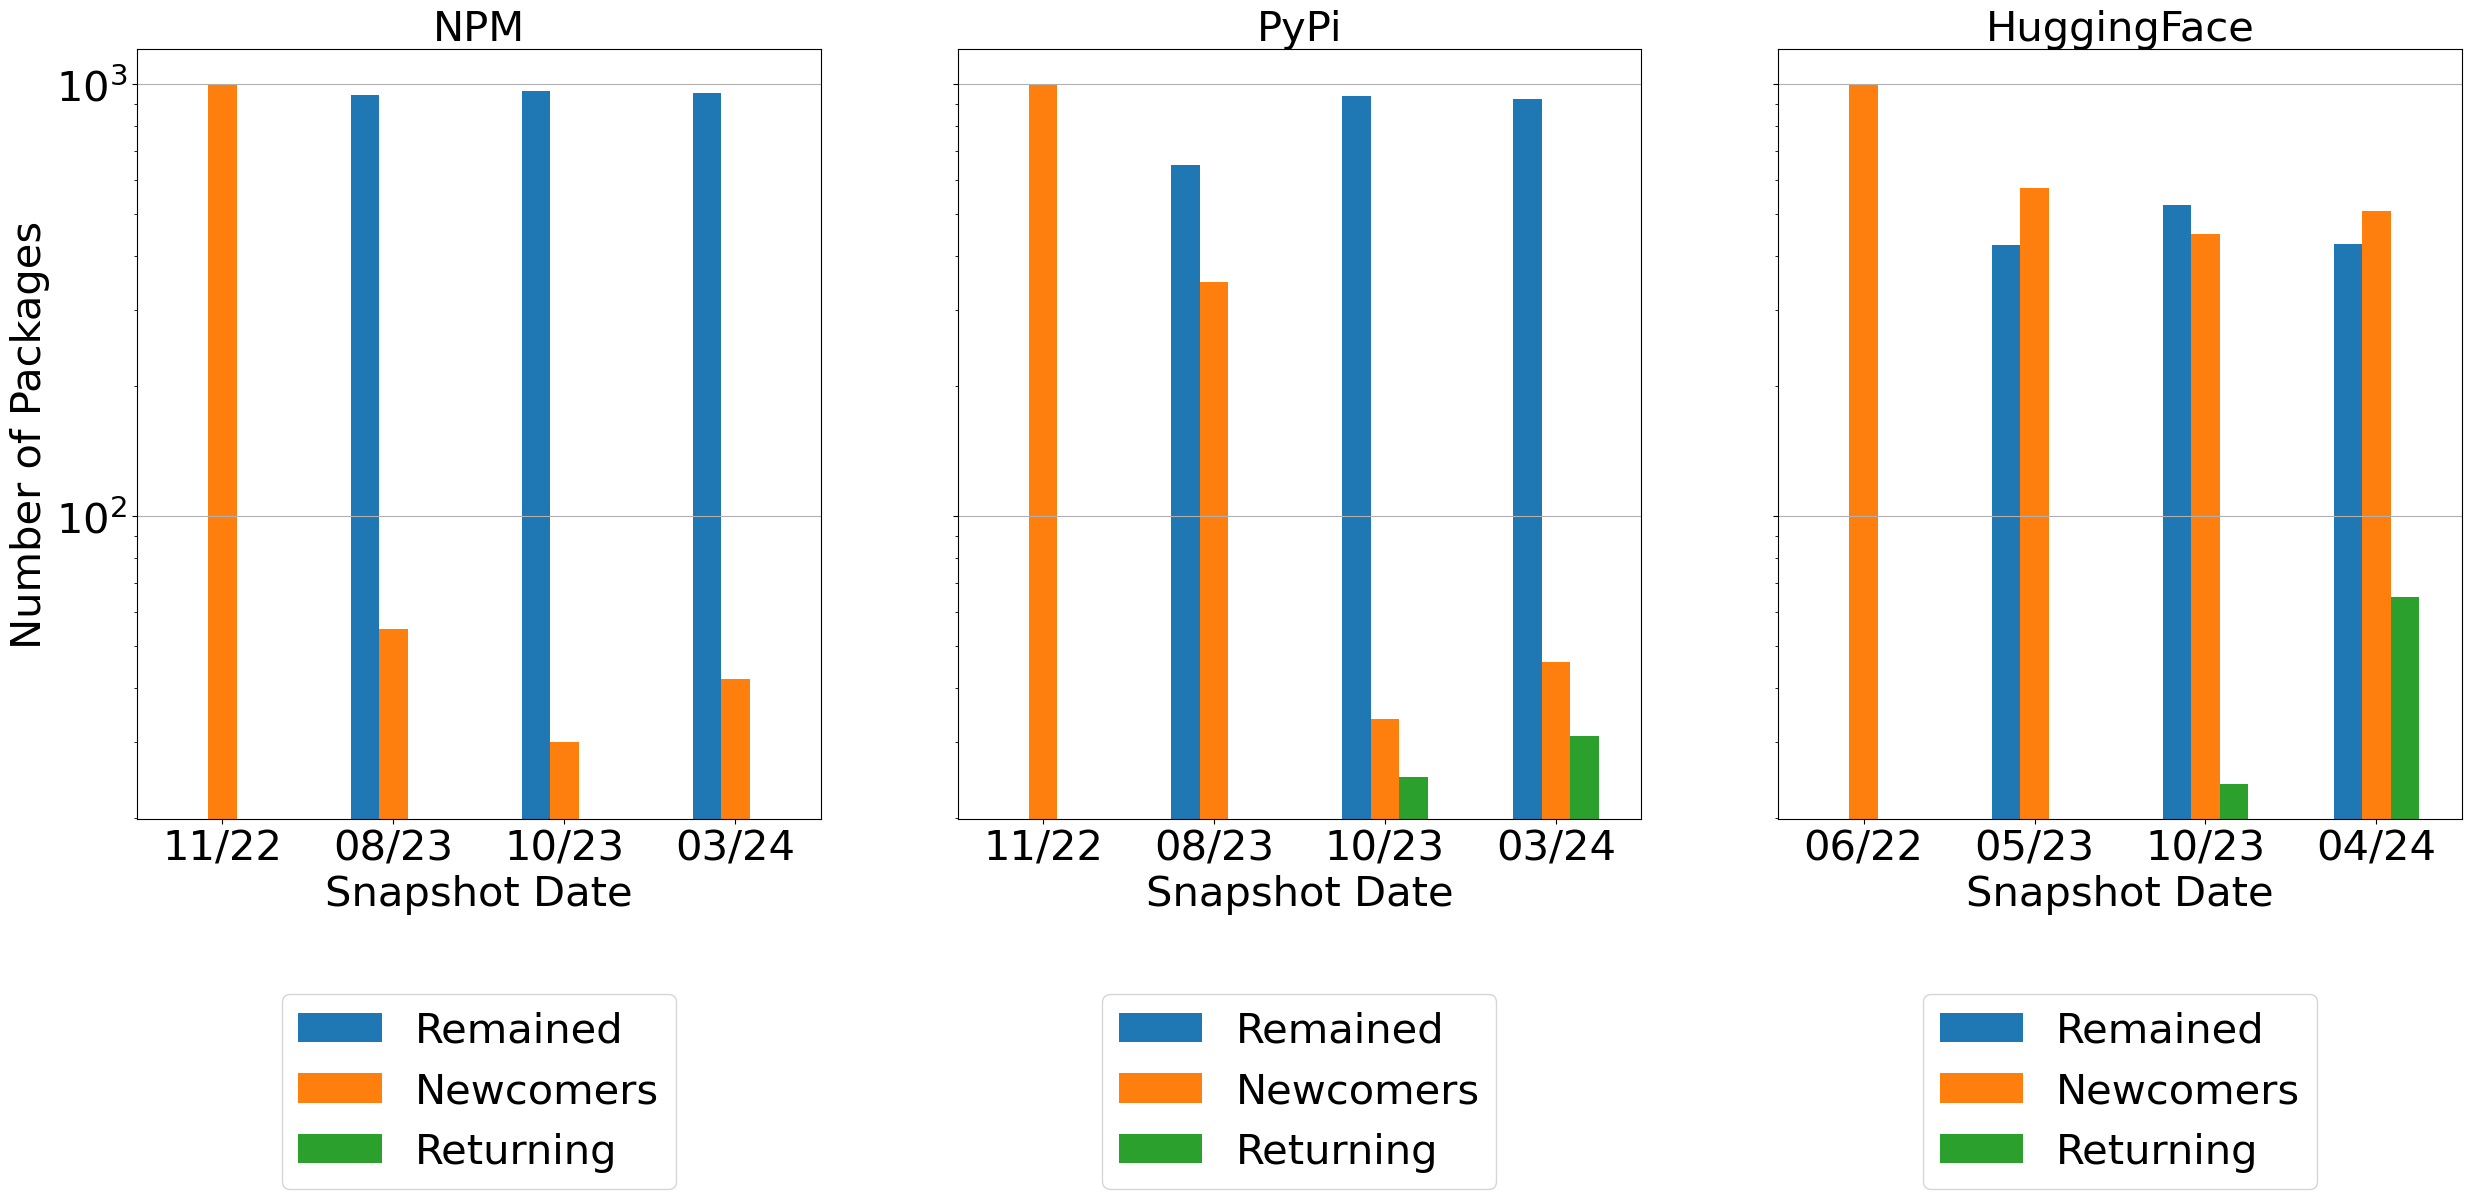

In [4]:
def get_top_packages_by_popularity(registry_id: int, database: str) -> pd.DataFrame | None:
    """
    Get the top packages by popularity from the database
    """
    query_result = query_psql(f"""
    SELECT name, ecosystem, downloads
    FROM packages
    WHERE registry_id = {registry_id}
    AND downloads IS NOT NULL
    ORDER BY downloads DESC
    LIMIT 1000;
    """, database=database)
    
    if query_result is not None:
        df = pd.DataFrame(query_result, columns=["Package Name", "Ecosystem", "Downloads"])
        return df
    else:
        return None

# Get the top packages by popularity for the NPM and PyPi registries from the databases:
# ecosystems_22_11
# ecosystems_23_08
# ecosystems_23_10
# ecosystems_24_03
def create_popularity_history(registry_id : int, databases: list[str]) -> list[pd.DataFrame]:
    history = []
    
    for i in range(len(databases)):
        history.append(get_top_packages_by_popularity(registry_id, databases[i]))

    return history

def create_hf_popularity_history() -> list[pd.DataFrame]:
    """
    Get the popularity history for the HuggingFace registry
    """
    # get the ancient popularity history
    ancient_history = query_sqlite3(f"""
                                SELECT modelid, downloads_last_month
                                FROM PeaTMOSS_ANCIENT
                                WHERE downloads_last_month IS NOT NULL
                                ORDER BY downloads_last_month DESC
                                LIMIT 1000;
                                """, db='PeaTMOSS_ANCIENT.db')
    ancient_history = pd.DataFrame(ancient_history, columns=["Package Name", "Downloads"])

    # get the old popularity history
    old_history = query_sqlite3(f"""
                                SELECT modelid, downloads
                                FROM PeaTMOSS_OLD
                                WHERE downloads IS NOT NULL
                                ORDER BY downloads DESC
                                LIMIT 1000;
                                """, db='PeaTMOSS_OLD.db')
    old_history = pd.DataFrame(old_history, columns=["Package Name", "Downloads"])

    # get the snapshot popularity history
    current_history = query_sqlite3(f"""
                                    SELECT context_id, downloads
                                    FROM model
                                    WHERE downloads IS NOT NULL
                                    ORDER BY downloads DESC
                                    LIMIT 1000;
                                    """)
    current_history = pd.DataFrame(current_history, columns=["Package Name", "Downloads"])

    # get the new popularity history
    new_history = query_sqlite3(f"""
                                SELECT id, downloads
                                FROM PeaTMOSS_NEW
                                WHERE downloads IS NOT NULL
                                ORDER BY downloads DESC
                                LIMIT 1000;
                                """, db='PeaTMOSS_NEW.db')
    new_history = pd.DataFrame(new_history, columns=["Package Name", "Downloads"])

    return [ancient_history, old_history, current_history, new_history]

def plot_package_turnover(history: list[pd.DataFrame], registry_name: str, dates : list[str], limit: int = 1000, axes: plt.Axes = None):
    """
    Plot the turnover of the top packages from the history
    Turnover is defined as the number of new packages that enter the top X packages each month
    This turnover is further broken down into 
    1st time newcomers,
    returning packages that are newcomers but have been within the top X before
    and remaining packages that stayed in the top X
    """
    turnover = [{"Time": dates[0], "Newcomers": limit, "Returning": 0, "Remained": 0}]
    have_ever_been_in_top = set(history[0]["Package Name"])
    last_top = have_ever_been_in_top
    for i in range(1, len(history)):
        current_top = set(history[i]["Package Name"])
        new_packages = current_top - last_top
        returnees = new_packages.intersection(have_ever_been_in_top)
        new_packages -= returnees
        remained = last_top.intersection(current_top)
        turnover.append({"Time": dates[i], "Newcomers": len(new_packages), "Returning": len(returnees), "Remained": len(remained)})
        last_top = current_top
        have_ever_been_in_top.update(new_packages)

    print(f"There are a total of {len(have_ever_been_in_top)} packages that have ever been in the top {limit} packages from {registry_name}")
    
    # Plot the turnover of the top packages as a bar graph with 3 bars, and the labels being tilted for better readability
    turnover_df = pd.DataFrame(turnover)
    if axes is None:
        axes = turnover_df.plot(kind='bar', x='Time', y=['Remained', 'Newcomers', 'Returning'], figsize=(10, 10))
    else:
        turnover_df.plot(kind='bar', x='Time', y=['Remained', 'Newcomers', 'Returning'], ax=axes, fontsize=30)
    
    axes.set_xticklabels(turnover_df["Time"], rotation=0, fontsize=30)
    axes.set_title(f"{registry_name}", fontsize=30)
    axes.set_ylabel("Number of Packages", fontsize=30)
    axes.set_xlabel("Snapshot Date", fontsize=30)
    axes.set_yscale('log')
    axes.legend(["Remained", "Newcomers", "Returning"], fontsize=30, loc='upper center', bbox_to_anchor=(0.5, -0.2))
    axes.yaxis.grid(True)
    return


databases = ["ecosystems_22_11", "ecosystems_23_08", "ecosystems_23_10", "ecosystems_24_03"]
dates = ["11/22", "08/23", "10/23", "03/24"]
npm_history: list[pd.DataFrame]
pypi_history: list[pd.DataFrame]
hf_history: list[pd.DataFrame]
npm_history = create_popularity_history(NPM, databases)
pypi_history = create_popularity_history(PYPI, databases)
hf_history = create_hf_popularity_history()

fig, axes = plt.subplots(1, 3, figsize=(30, 10), sharey=True)

plot_package_turnover(npm_history, "NPM", dates, 1000, axes=axes[0])
plot_package_turnover(pypi_history, "PyPi", dates, 1000, axes=axes[1])
plot_package_turnover(hf_history, "HuggingFace", ["06/22", "05/23", "10/23", "04/24"], 1000, axes=axes[2])
